In [1]:
import pystac_client
import planetary_computer as pc

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

In [2]:
# reduce box has to be in itemid scene

def open_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)
    
    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)


    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)

    win = ds.window(*reduce.total_bounds)
    subset = rasterio.open(href).read([1,2,3,4], window=win)
    return subset

In [3]:
itemid='ca_m_3411934_sw_11_060_20180722_20190209'

#Only Campus Point
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])

# reduce_box = Polygon([
#     [-119.8486219719,34.4050404477],
#     [-119.845895134,34.4050404477],
#     [-119.845895134,34.4071308966],
#     [-119.8486219719,34.4071308966],
#     [-119.8486219719,34.4050404477]])

In [4]:
subset = open_window_in_scene(itemid, reduce_box)

In [5]:
subset.shape

(4, 1923, 1967)

In [6]:
# reshape image into a np.array where each row is a pixel and the columns are the bands
pixels = subset.reshape([4,-1]).T
pixels

array([[111, 107, 109,  87],
       [114, 108, 110,  93],
       [109, 104, 110,  89],
       ...,
       [141, 149, 162,  96],
       [150, 164, 162, 107],
       [180, 175, 172,  95]], dtype=uint8)

In [7]:
pixels.shape

(3782541, 4)

In [8]:
df = pd.DataFrame(pixels, columns=['r','g','b','nir'])

In [9]:
df

,r,g,b,nir
0,111,107,109,87
1,114,108,110,93
2,109,104,110,89
3,111,107,109,90
4,113,109,109,93
...,...,...,...,...
3782536,185,185,179,145
3782537,188,185,191,118
3782538,141,149,162,96
3782539,150,164,162,107


In [10]:
df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
df

,r,g,b,nir,ndvi
0,111,107,109,87,-0.121212
1,114,108,110,93,-0.101449
2,109,104,110,89,-0.101010
3,111,107,109,90,-0.104478
4,113,109,109,93,-0.097087
...,...,...,...,...,...
3782536,185,185,179,145,-0.121212
3782537,188,185,191,118,-0.228758
3782538,141,149,162,96,-0.189873
3782539,150,164,162,107,-0.167315


In [11]:
vegetation = df[df.ndvi>0.2]
vegetation

,r,g,b,nir,ndvi
30,95,92,98,156,0.243028
33,101,102,103,157,0.217054
34,98,100,99,148,0.203252
35,93,95,98,142,0.208511
36,82,81,89,153,0.302128
...,...,...,...,...,...
3780676,37,48,62,56,0.204301
3780679,33,46,62,52,0.223529
3780680,40,49,64,62,0.215686
3780681,38,48,63,68,0.283019


In [12]:
df.shape[0] - vegetation.shape[0]

3248411

In [13]:
vegetation.index[0]

30

In [14]:
empty = np.zeros((subset.shape[1],subset.shape[2]))
empty.shape

(1923, 1967)

In [15]:
for n in vegetation.index:
    i = int((n)/empty.shape[1])
    j = (n) % empty.shape[1]
    empty[i][j] = 1
empty

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

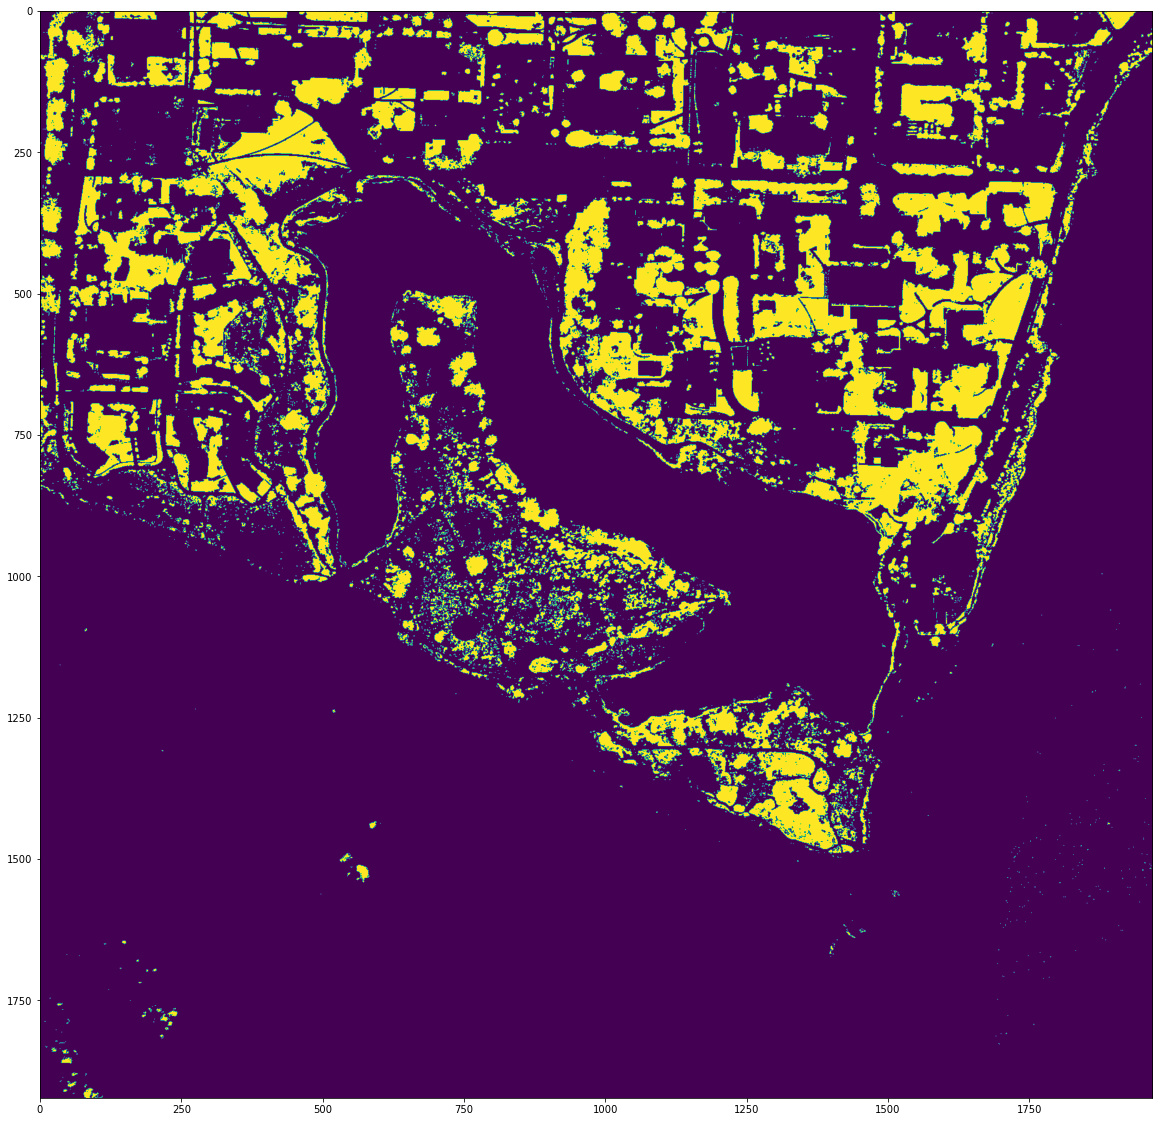

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(empty)
plt.show()